## Global Config

In [18]:
# download configuratiins
download_from_remote = True
load_from_local = True
save_to_local = True
local_dataset = "./dataset/fever_dataset"
local_adversarial = "./dataset/adversarial_dataset"
%mkdir -p {local_dataset}
%mkdir -p {local_adversarial}

# data analytics
test_tokenizer = True
print_statistics = True
print_ag_statistics = True

# dataset exploration
general_structure = True
show_ids = False
show_labels = False
wsd_exploration = False
srl_exploration = False

# semantic roles
save_info = False
info = "./info/"
%mkdir -p {info}

# augmentation
mv_augment = False
mr_augment = False
br_augment = False
syn_hyp_augment = True

# graph
make_graph = False
save_graph = True
load_graph = True
graph = "./relational_graph"
%mkdir -p {graph}
augmentation_dir = "./augmentation"
%mkdir -p {augmentation_dir}
%mkdir -p {augmentation_dir}"/datasets"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

## Imports

In [2]:
# general imports
import os
import re
import json
import string
import random
from tqdm import tqdm

# visualization and statistics
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# data manipulation
import numpy as np
import pandas as pd
from typing import Dict
from datasets import(
  Dataset, 
  load_dataset, 
  load_from_disk, 
  concatenate_datasets,
) 

# nltk
import nltk
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
nltk.download('wordnet')

# spacy
import spacy 
# Load the SpaCy model
nlp_spacy = spacy.load("en_core_web_sm")

# huggingface
from transformers import DataCollatorWithPadding
from transformers import (
    AutoTokenizer,
    set_seed,
)

# set seeds
set_seed(42)
# torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

/home/leeoos/miniconda3/envs/nlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to /home/leeoos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /home/leeoos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data

In [3]:
#@title Download data or just load from local 

download_from_remote = not(os.path.exists(local_dataset) and os.path.exists(local_adversarial))

if download_from_remote:
    print("Downloading data from remote repository")

    # load chunk of FEVER datyaset
    fever_dataset = load_dataset("tommasobonomo/sem_augmented_fever_nli", trust_remote_code=True)

    # load adversarial 
    adversarial_testset = load_dataset("iperbole/adversarial_fever_nli", trust_remote_code=True)

    # structure of the dataset
    print(fever_dataset)

    if save_to_local:
        print(f"Save data in local {local_dataset}")
        fever_dataset.save_to_disk(local_dataset)
        print(f"Save adversarial dataset in {local_adversarial}")
        adversarial_testset.save_to_disk(local_adversarial)

elif load_from_local and os.path.exists(local_dataset) and os.path.exists(local_adversarial):
    print(f"Load data from local repository")
    fever_dataset = load_from_disk(local_dataset)
    adversarial_testset = load_from_disk(local_adversarial)
    
print("Done!")

print(f"Train ssplit length: {len(fever_dataset['train'])}")
max_id = max(fever_dataset['train']['id'])
print(f"Max id in train split: {max_id}")

Load data from local repository
Done!
Train ssplit length: 51086
Max id in train split: 99998


## Exploration

In [4]:
#@title Tokenization function for datapoint visualization

if test_tokenizer:
        
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    label_map = {
        'ENTAILMENT': 0,
        'NEUTRAL': 1,
        'CONTRADICTION': 2,
        'NOT ENOUGH INFO': None
    }

    def tokenize_function(examples):
        examples['label'] = [label_map[label] for label in examples['label']]
        return tokenizer(examples['premise'], examples['hypothesis'], padding=True, truncation=True)


    # tokenized = fever_dataset.map(tokenize_function, batched=True)

In [5]:
#@title Exploration utils

def pretty_print_dict(d, indent=0):
    for key, value in d.items():
        print(' ' * indent + str(key) + ':', end=' ')
        if isinstance(value, dict):
            print()
            pretty_print_dict(value, indent + 4)
        else:
            print(value)


def plot_labels_distribution(target_set, title='', colors=['#FF9999', '#66B2FF', '#99FF99']):
    labels = [
        'ENTAILMENT',
        'NEUTRAL',
        'CONTRADICTION',
    ]

    label_counts = {}
    for label in target_set['label']:
        if label not in label_counts:
            label_counts[label] = 0
        label_counts[label] += 1

    plt.figure(figsize=(10, 6))  # Optional: set figure size
    plt.bar(labels, label_counts.values(), color=colors)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title(f'Distribution of labels in {title}')
    
    # Optional: Add value labels on top of each bar
    for i, v in enumerate(label_counts.values()):
        plt.text(i, v, str(v), ha='center', va='bottom')

    plt.show()
    print()

def analyze_token_frequency(dataset, tokenizer, top_n=20):
    # Flatten all input_ids into a single list
    all_tokens = [token for seq in dataset['input_ids'] for token in seq]
    
    # Count token occurrences
    token_counts = Counter(all_tokens)
    
    # Get the most common tokens
    most_common = token_counts.most_common(top_n)
    
    # Plotting
    tokens, counts = zip(*most_common)
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(counts)), counts)
    plt.xlabel('Token ID')
    plt.ylabel('Frequency')
    plt.title(f'Top {top_n} Most Frequent Tokens')
    plt.xticks(range(len(counts)), tokens, rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Total tokens: {len(all_tokens)}")
    print(f"Unique tokens: {len(token_counts)}")
    print("\nMost common tokens:")
    for token, count in most_common:
        print(f"Token ID {token}: {count} occurrences")

    print("\nMost common tokens:")
    for token, count in tqdm(most_common):
        decoded = tokenizer.decode([token])
        print(f"Token ID {token} ('{decoded}'): {count} occurrences")


# legacy
def plot_lengths_distribution(target_set, title='', compare_length=False):
    # extract premises and hypotheses
    premises = [item['premise'] for item in target_set]
    hypotheses = [item['hypothesis'] for item in target_set]

    # compute lengths
    premise_lengths = [len(premise.split()) for premise in premises]
    hypothesis_lengths = [len(hypothesis.split()) for hypothesis in hypotheses]

    # plotting length distributions
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.histplot(premise_lengths, bins=50, kde=True, ax=axes[0], color='blue', log_scale=(False, True))
    axes[0].set_title('Premise Length Distribution')
    axes[0].set_xlabel('Number of Words')
    axes[0].set_ylabel('Frequency')

    sns.histplot(hypothesis_lengths, bins=50, kde=True, ax=axes[1], color='green', log_scale=(False, True))
    axes[1].set_title('Hypothesis Length Distribution')
    axes[1].set_xlabel('Number of Words')
    axes[1].set_ylabel('Frequency')

    fig.suptitle(f'Premise and Hypothesis Length Distribution in {title}')
    plt.show()

    if compare_length:
        # plot premise vs hypothesis length scatter plot
        plt.figure(figsize=(8, 6))
        plt.scatter(premise_lengths, hypothesis_lengths, alpha=0.5, s=1)
        plt.title('Premise vs Hypothesis Length')
        plt.xlabel('Premise Length')
        plt.ylabel('Hypothesis Length')
        plt.yscale('log')
        plt.xscale('log')
        plt.grid(True, which="both", ls="--")
        plt.show()

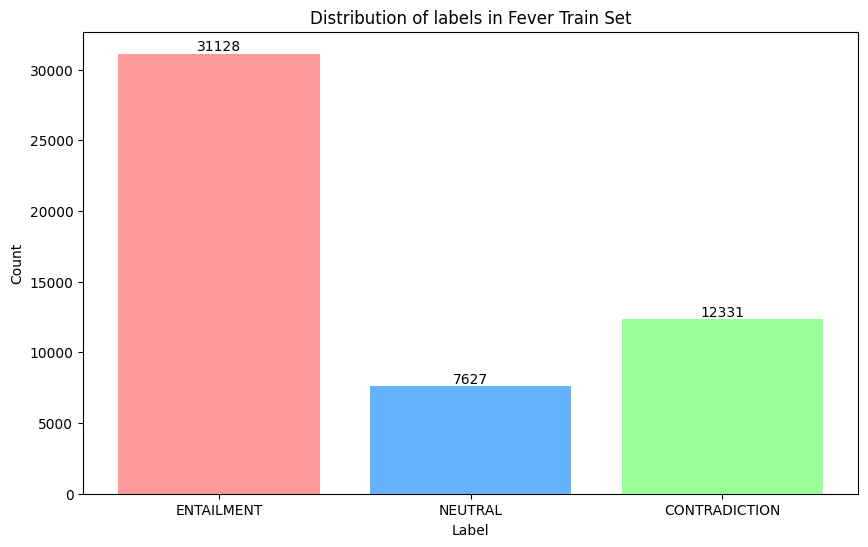

Map: 100%|██████████| 2288/2288 [00:00<00:00, 7580.53 examples/s]


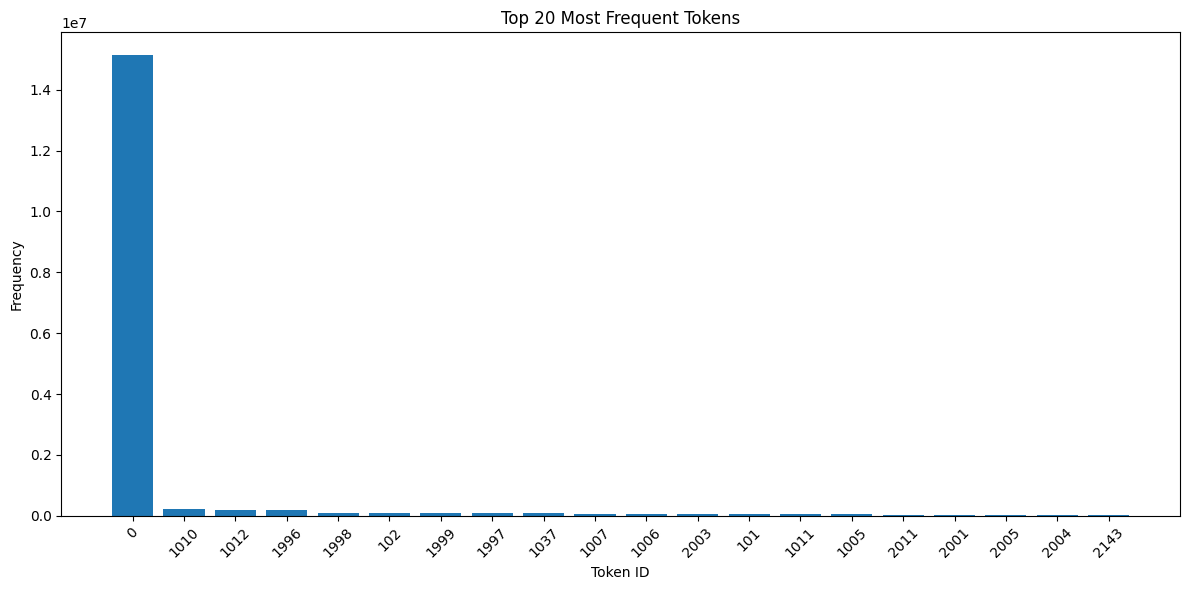

Total tokens: 19404358
Unique tokens: 22212

Most common tokens:
Token ID 0: 15131015 occurrences
Token ID 1010: 222441 occurrences
Token ID 1012: 202752 occurrences
Token ID 1996: 184912 occurrences
Token ID 1998: 102999 occurrences
Token ID 102: 102172 occurrences
Token ID 1999: 88866 occurrences
Token ID 1997: 77577 occurrences
Token ID 1037: 75793 occurrences
Token ID 1007: 64341 occurrences
Token ID 1006: 64214 occurrences
Token ID 2003: 63118 occurrences
Token ID 101: 51086 occurrences
Token ID 1011: 50815 occurrences
Token ID 1005: 46019 occurrences
Token ID 2011: 32789 occurrences
Token ID 2001: 31858 occurrences
Token ID 2005: 30806 occurrences
Token ID 2004: 30471 occurrences
Token ID 2143: 28956 occurrences

Most common tokens:


100%|██████████| 20/20 [00:00<00:00, 52167.96it/s]

Token ID 0 ('[PAD]'): 15131015 occurrences
Token ID 1010 (','): 222441 occurrences
Token ID 1012 ('.'): 202752 occurrences
Token ID 1996 ('the'): 184912 occurrences
Token ID 1998 ('and'): 102999 occurrences
Token ID 102 ('[SEP]'): 102172 occurrences
Token ID 1999 ('in'): 88866 occurrences
Token ID 1997 ('of'): 77577 occurrences
Token ID 1037 ('a'): 75793 occurrences
Token ID 1007 (')'): 64341 occurrences
Token ID 1006 ('('): 64214 occurrences
Token ID 2003 ('is'): 63118 occurrences
Token ID 101 ('[CLS]'): 51086 occurrences
Token ID 1011 ('-'): 50815 occurrences
Token ID 1005 ('''): 46019 occurrences
Token ID 2011 ('by'): 32789 occurrences
Token ID 2001 ('was'): 31858 occurrences
Token ID 2005 ('for'): 30806 occurrences
Token ID 2004 ('as'): 30471 occurrences
Token ID 2143 ('film'): 28956 occurrences


In [6]:
#@title Statistics about the regular dataset
if print_statistics:
  plot_labels_distribution(fever_dataset['train'], title="Fever Train Set")
  tokenized_fever_dataset = fever_dataset.map(tokenize_function, batched=True)
  analyze_token_frequency(tokenized_fever_dataset['train'], tokenizer)
  # plot_lengths_distribution(fever_dataset['train'], title="Fever Train Set", compare_length=True)

In [7]:
#@title Dataset structure

if general_structure:
  print(f"Datasets structure: {fever_dataset}")

if show_ids:
  print(f"Train IDs: {fever_dataset['train']['id']}")

if show_labels:
  print(f"Train labels: {fever_dataset['train']['label']}")


if wsd_exploration:

  print(f"\nWSD srtructure: ")
  pretty_print_dict(fever_dataset['train'][42]['wsd'])

  sample_range = len(fever_dataset['train'])
  loop = tqdm(range(sample_range))

  wsd_info = dict()
  wsd_info['pos'] = dict()

  for i in loop:

    data =  fever_dataset['train'][i]
    sample_id = data['id']

    hypothesis = data['hypothesis']
    hyp_wsd = data['wsd']['hypothesis']

    for hyp_wsd_dict in hyp_wsd:
      
      pos  = hyp_wsd_dict['pos']
      wsd_info['pos'][pos] = 1 if pos not in wsd_info['pos'] else wsd_info['pos'][pos] + 1

  print("POS:")
  pretty_print_dict(wsd_info)

  with open(info + "wsd_pos.txt", "w") as wsd_pos:
    print(f"Saving allPOS of the dataset into {info + 'wsd_pos.txt'}")
    for elem in wsd_info['pos']: wsd_pos.write(f"{elem}\n")



if srl_exploration:
  print("\nSRL structure: ")
  print(fever_dataset['train'][42]['srl'].keys())
  # print(fever_dataset['train'][42]['srl']['hypothesis']['tokens'])
  # print(fever_dataset['train'][42]['srl']['hypothesis']['annotations'])

  print("Tokens: ")
  for token in fever_dataset['train'][42]['srl']['premise']['tokens']:
      print(token)

  print("\nAnnotations: ")
  for annotation in fever_dataset['train'][42]['srl']['premise']['annotations']:
      for key, value in annotation.items():
          print(f"{key}:\t{value}")
      print()

Datasets structure: DatasetDict({
    train: Dataset({
        features: ['id', 'premise', 'hypothesis', 'label', 'wsd', 'srl'],
        num_rows: 51086
    })
    validation: Dataset({
        features: ['id', 'premise', 'hypothesis', 'label', 'wsd', 'srl'],
        num_rows: 2288
    })
    test: Dataset({
        features: ['id', 'premise', 'hypothesis', 'label', 'wsd', 'srl'],
        num_rows: 2287
    })
})


In [48]:
#@title SRL exploration: collect frame-names and roles 

def get_srl_info(dataset):

  sample_range = len(dataset)
  loop = tqdm(range(sample_range))

  verbs_freqs = dict()
  set_of_va_frames = dict() # verb atlas frames
  set_of_pb_frames = dict() # prop bank frames
  set_of_va_roles = set() # verb atlas frames
  set_of_pb_roles = set() # prop bank frames

  for i in loop:

    data =  dataset[i]
    sample_id = data['id']
    
    tokens = data['srl']['premise']['tokens']
    annotations = data['srl']['premise']['annotations']

    for annotation in annotations:

      token_index = annotation['tokenIndex']
      verb = tokens[token_index]['rawText']
      verbs_freqs[verb] =  1 if verb not in  verbs_freqs else verbs_freqs[verb] + 1

      vb_frame = annotation['verbatlas']['frameName']
      pb_frame = annotation['englishPropbank']['frameName']

      set_of_va_frames[vb_frame] = 1 if vb_frame not in set_of_va_frames else set_of_va_frames[vb_frame] + 1 
      set_of_pb_frames[pb_frame] = 1 if pb_frame not in set_of_pb_frames else set_of_pb_frames[pb_frame] + 1 

      va_roles = annotation['verbatlas']['roles']
      pb_roles = annotation['englishPropbank']['roles']

      for role in va_roles:
        set_of_va_roles.add(role['role'])

      for role in pb_roles:
        set_of_pb_roles.add(role['role'])

  return set_of_va_frames, set_of_pb_frames, set_of_va_roles, set_of_pb_roles, verbs_freqs
  

In [49]:
if save_info:

  set_of_va_frames, set_of_pb_frames, set_of_va_roles, set_of_pb_roles, verbs_freqs = get_srl_info(fever_dataset['train'])

  verbs_freqs = sorted(verbs_freqs.items(), key=lambda item: item[1], reverse=True)
  set_of_pb_frames = sorted(set_of_pb_frames.items(), key=lambda item: item[1], reverse=True)
  set_of_va_frames = sorted(set_of_va_frames.items(), key=lambda item: item[1], reverse=True)

  print(f"Number of Verb Atlas frames: {len(set_of_va_frames)}")
  print(f"Number of Verb Atlas roles: {len(set_of_va_roles)}")

  print(f"Number of Propbank frames: {len(set_of_pb_frames)}")
  print(f"Number of Propbank roles: {len(set_of_pb_roles)}")

  with open(info + "va_roles.txt", "w") as va_roles:
    print(f"Saving all Verb Atlas roles of the dataset into {info + 'va_roles.txt'}")
    for elem in set_of_va_roles: va_roles.write(f"{elem}\n")

  with open(info + "va_frames.txt", "w") as va_frames:
    print(f"Saving all Verb Atlas frames of the dataset into {info + 'va_frames.txt'}")
    for elem in set_of_va_frames: va_frames.write(f"{elem}\n")


  with open(info + "pb_roles.txt", "w") as pb_roles:
    print(f"Saving all Propbank roles of the dataset into {info + 'pb_roles.txt'}")
    for elem in set_of_pb_roles: pb_roles.write(f"{elem}\n")


  with open(info + "pb_frames.txt", "w") as pb_frames:
    print(f"Saving all Propbank frames of the dataset into {info + 'pb_frames.txt'}")
    for elem in set_of_pb_frames: pb_frames.write(f"{elem}\n")

  with open(info + "verbs_freqs.txt", "w") as verbs:
    print(f"Saving all verbs frequencies count into {info + 'verbs_freqs.txt'}")
    for elem in verbs_freqs: verbs.write(f"{elem}\n")


## Augmentation

GPT prompts to "correct" the sentencies

Marridge samples:
"Can you rephrase this sentences by substituting the verb "married" with another expression the tell the same concept. The expressions used have to be diverse while a small amount of repetition is allowed. Even leaving "married" could be an option. Finally follow this guidelines:
1. If the subject is wrong (e.g. Europe married Jennifer Lawrence) then skip the sentence
2. If the object is wrong (e.g. Jennifer Lawrence married Europe) change the object but make sure to not use real facts. Please write everithing to in a txt file and keep the format: 
id sentence "

Borne samples:
"Can you rephrase this sentences by inserting a random action, still plausible in the context of the sentence, in place of -did something-. The action has to be diverse while a small amount of repetition is allowed. Please write everithing to in a txt file and keep the format: 
id sentence "

#### Utilities

In [8]:
#@title Augmentation utils

def load_file(filename):
    file_path = f'{augmentation_dir}/{filename}.txt'  # Update the path to your file
    lines = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
    return lines


def get_sentence_from_span(tokens, span_begin, span_end):
    sentence = ""
    try: 
      sentence = " ".join([tokens[index]['rawText']  for index in range(span_begin, span_end + 1)]) # if tokens[index]['rawText'] in names])
    except:
      sentence = " ".join([tokens[index]['rawText'] for index in range(span_begin, span_end)]) #if tokens[index]['rawText'] in names])

    return sentence


def join_strings_smartly(words):
    """ Joins a list of words smartly:
    - Adds spaces between words when appropriate.
    - Avoids adding spaces before punctuation.
    """
    punctuation = {'.', ',', ';', ':', '!', '?',')'}
    result = words[0]
    prev = result

    for word in words[1:]:
      if word in punctuation or \
        ("'" in prev) or \
        word.startswith("'") or \
        ("." in prev and "." in word) or \
        ("(" in prev) :
        # add word without space before
        result += word
      else:
        # add with space before
        result += " " + word
      # keep track of previous word  
      prev = word

    return result

def get_synset_from_id(synset_id):
    if synset_id == 'O':
        return None
    try:
        offset = int(''.join(filter(str.isdigit, synset_id)))
        pos = synset_id[-1]
        synset = wn.synset_from_pos_and_offset(pos, offset)
        return synset
    except:
        print("exception")
        return None
    

def get_related_word(synset, pos): 
    info = dict()

    # Map POS tags to WordNet POS tags
    pos_map = {
        'NOUN': wn.NOUN,
        # 'VERB': wn.VERB,
        'ADJ': wn.ADJ,
        'ADV': wn.ADV
    }
    
    if pos not in pos_map:
        return None 
    
    # get hypernyms
    hypernyms = synset.hypernyms()
    if not hypernyms:
        return None
    hypernyms = synset.hypernyms()
    # hypernym_words = set()
    # for hypernym in hypernyms:
    #     hypernym_words.update(hypernym.lemma_names())
    info['hypernyms'] = [hypernyms[0].lemma_names()[0]] #list(hypernym_words)

    # get synonyms 
    synonyms = synset.lemmas()
    if not synonyms:
        return None
    info['synonyms'] = [synonym.name() for synonym in synonyms if synonym.name() != synset.lemmas()[0].name()]

    return info

def get_examples(synset, word):
    pos_map = {
        'NOUN': wn.NOUN,
        # 'VERB': wn.VERB,
        'ADJ': wn.ADJ,
        # 'ADV': wn.ADV
    }

    if pos not in pos_map:
        return None 

    all_synsets = wn.synsets(word)

    # collect examples from all other synsets
    all_examples = []
    for s in all_synsets:
        if s != synset:
            all_examples.extend(s.examples())

    if all_examples: return random.choice(all_examples)
    else: None


def extract_names(wsd_data):
    names = []
    current_name = []

    for entry in wsd_data:
        if entry['pos'] == 'PROPN':
            current_name.append(entry['text'])
        else:
            if current_name:
                names.append(' '.join(current_name))
                current_name = []

    # catch any remaining name at the end
    if current_name:
        names.append(' '.join(current_name))
    
    return names


def extract_partial_match_name(text, name_list):
    # tokenize the input text
    words = re.findall(r'\b\w+\b', text)
    names = []
    
    # iterate through each name in the name list
    for name in name_list:
        name_parts = name.split()

        # check for partial match in the tokenized words
        for i in range(len(words) - len(name_parts) + 1):
            if words[i:i + len(name_parts)] == name_parts[:len(words[i:i + len(name_parts)])]:
              names.append(name)
              
    if names: return names
    return None


def extract_dates(text):
    # regular expression patterns for different date formats
    patterns = [
        r'\b(\d{4})\b',  # matches a 4-digit year
        r'\b(\d{1,2}[/-]\d{1,2}[/-]\d{2,4})\b',  # matches dates like dd-mm-yyyy, dd/mm/yyyy, dd-mm-yy, dd/mm/yy
        r'\b(\d{1,2} [A-Za-z]+ \d{4})\b',  # matches dates like 1 January 2020
        r'\b([A-Za-z]+ \d{1,2}, \d{4})\b'  # matches dates like January 1, 2020
    ]

    months_list = [
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ]

    pattern = re.compile(r'(?:(?P<day>\d{1,2})(?:st|nd|rd|th)?[ ,]*)?(?:(?P<month>[A-Za-z]+)[ ,]*)?(?:(?P<year>\d{4}))?')
    matches = pattern.findall(text)
    day, month, year = None, None, None

    for match in matches:
        if match[0]:
            day = match[0]
        if match[1]:
            month = match[1]
        if match[2]:
            year = match[2]
        
        # more check to avoid error!
        if day and not (1 <= int(day) <= 31):
            day = None
        if month and month not in months_list:
            month = None
            
    return day, month, year

def extract_locations(sentence):
    locations = set()
    entities =  nlp_spacy(sentence).ents
    if entities:
        found_target = False
        for ent in entities:
            if ent.label_ == "GPE":
                found_target = True
                locations.add(ent.text)
    return locations


movie_titles = [
    "John Wick: Chapter 2",
    "On the Road (film)",
    "Brave",
    "Penny Dreadful",
    "Snooki & Jwoww",
    "Sons of Anarchy",
    "The Sopranos",
    "Thor: The Dark World",
    "Winter Passing",
    "Teen Wolf",
    "Captain America: The Winter Soldier",
    "The Belko Experiment",
    "Fantastic Beasts and Where to Find Them",
    "A Monster Calls",
    "The Fate of the Furious",
    "The Wolf of Wall Street (2013 film)",
    "Tropico",
    "Rescue Me",
    "The Night Of",
    "Lipstick Under My Burkha",
    "The Promise",
    "Sleeping Beauty",
    "Mad Men",
    "Avatar",
    "Zootopia",
    "Spider-Man",
    "Enemy",
    "Room",
    "Cloud Atlas",
    "Kong: Skull Island",
    "Rick and Morty",
    "Ink Master",
    "Frenemies",
    "Persuasion (2007 film)",
    "Ballet Shoes",
    "The Great Buck Howard",
    "Schindler's List",
    "Iron Man",
    "The Illusionist",
    "The Messenger",
    "The Suite Life Movie",
    "Wild",
    "The Ren & Stimpy Show",
    "Johnny Mnemonic",
    "Denial (2016 film)",
    "Black Sails",
    "The Breakfast Club",
    "Modern Family",
    "Interstellar",
    "To the Bone",
    "Prison Break",
    "Game of Thrones (season 3)",
    "Line of Duty",
    "In the Heart of the Sea",
    "Oz the Great and Powerful",
    "Attack on Titan",
    "Her",
    "The Carmichael Show",
    "The Leftovers",
    "Short Term 12",
    "Stephanie Daley",
    "Fargo",
    "BoJack Horseman",
    "New Girl",
    "Glee",
    "Turn: Washington's Spies",
    "X-Men: Days of Future Past",
    "Miss Peregrine's Home for Peculiar Children",
    "Ghostbusters",
    "Famous in Love",
    "Legion",
    "Spider-Man 3",
    "Deadpool (film)",
    "Doctor Who",
    "San Junipero",
    "Outlander (TV series)",
    "Elementary",
    "The Shield",
    "Broadchurch",
    "Fairy Tail",
    "Major Barbara",
    "American Horror Story",
    "Trolls",
    "Harry Potter",
    "Whiplash",
    "Split (2016 American film)",
    "How to Be",
    "Cars Toons",
    "Little Miss Sunshine",
    "Naruto",
    "Horrible Bosses",
    "There Will Be Blood",
    "Beauty and the Beast",
    "Grey's Anatomy",
    "Futurama",
    "The Strain",
    "The Avengers",
    "The Vampire Diaries",
    "True Detective",
    "Teen Wolf's sixth season",
    "Interview",
    "The Supernatural",
    "The Girl on the Train",
    "Interstellar",
    "Guardians of the Galaxy",
    "Miss Peregrine's Home for Peculiar Children",
    "Love & Friendship",
    "Goliyon Ki Raasleela Ram-Leela"
]

def get_movie_title(sentence):
    for title in movie_titles:
        if re.search(r'\b' + re.escape(title) + r'\b', sentence):
            return title

# add new samples to the dataset
# filtered_dataset = fever_dataset['train'].filter(lambda example: 'is a ' in example['premise'].lower()) # or 'is a' in example['hypothesis'].lower())

In [9]:
#@title Graph utils

def get_premise_by_id(dataset, id):
  index = dataset['id'].index(str(id))
  # print(dataset[index]['premise'])
  # print(dataset[index]['hypothesis'])
  return dataset[index]['premise']

def format_date(dates):
  select_date = None
  for date in dates:
    if not date: continue
    if not date[2]: continue
    if date[2]: select_date = date[2]
    if date[1] and date[2]: select_date = date[1] + ", " + date[2]
    if date[0] and date[1] and date[2]:
      select_date = date[1] + " " + date[0] + ", " + date[2]
      break
  return select_date


def get_all_locations(graph, frame):
  ...
  all_locations = set()
  for key in graph[frame].keys():
    for location in graph[frame][key]['locations']:
      all_locations.add(location)
  return list(all_locations)


def get_all_dates(graph, frame):
  ...
  all_dates = set()
  for key in graph[frame].keys():
    date = format_date( graph[frame][key]['date'])
    all_dates.add(date)
  return list(all_dates)


location_hierarchy = {
   "United States": [
      "California", 
      "Texas", 
      "Illinois", 
      "District of Columbia",
      "New York",
      "New York City",
      "Washington",
      "D.C.",
      "Chicago",
      "Austin",
      "Hollywood",
      "Los Angeles"
    ],
   "the United States": [
      "California", 
      "Texas", 
      "Illinois", 
      "District of Columbia",
      "New York",
      "New York City",
      "Washington",
      "D.C.",
      "Chicago",
      "Austin",
      "Hollywood",
      "Los Angeles"
    ],
   "US": [
      "California", 
      "Texas", 
      "Illinois", 
      "District of Columbia",
      "New York",
      "New York City",
      "Washington",
      "D.C.",
      "Chicago",
      "Austin",
      "Hollywood",
      "Los Angeles"
    ],
    "California": ["Hollywood", "Los Angeles"],
    "Texas": ["Austin"],
    "Illinois": ["Chicago"],
    "District of Columbia": ["Washington", "D.C."],
    "New York": ["New York City"],
    "Canada": ["Alberta", "Edmonton"],
    "Japan": ["Tokyo"],
    "Australia":  ["Sydney"],
    "Germany": ["Berlin"],
    "Belgium": ["Belgium"],
    "Philippines": ["Philippines"],
    "United Kingdom": ["London"]
}

def is_contained(location, container, location_hierarchy):
  
  if container in location_hierarchy:
    if location in location_hierarchy[container]: 
      return True

  return False

def get_random_exclusive_element(main_list, exclusion_list):
  exclusion_set = set(exclusion_list)
  filtered_list = [item for item in main_list if item not in exclusion_set]
  
  if not filtered_list: return None  
  choice = random.choice(filtered_list)
  check = True
  while check:
    choice = random.choice(filtered_list)
    for location in exclusion_list:
      related = is_contained(choice, location, location_hierarchy) or is_contained(location, choice, location_hierarchy) or choice == 'Netflix' or choice == 'Spike'
      if not related: 
        check = False
        break
    
  return choice

# print(is_contained("the United States", "Tokyo", location_hierarchy))  # True
# print(is_contained("Tokyo", "the United States", location_hierarchy))  # True

def get_all_spouses(graph, frame):
  ...
  all_spouses = set()
  for key in graph[frame].keys():
    for spouse in graph[frame][key]['spouses']:
      all_spouses.add(spouse)
  return list(all_spouses)

def get_new_spouses(main_list, exclusion_list):
  ...
  exclusion_set = set(exclusion_list)
  filtered_list = [item for item in main_list if item not in exclusion_set]
  
  if not filtered_list: return None  
  return  random.choice(filtered_list)

# filtered_dataset = fever_dataset['train'].filter(lambda example: 'born in ' in example['premise'].lower()) # or 'is a' in example['hypothesis'].lower())

#### Relational Graph

In [10]:
#@title Build relational graph

# dataset = filtered_dataset
dataset = fever_dataset['train']

sample_range = len(dataset)
loop = tqdm(range(sample_range))

accetable_verbs = ['marry.01', 'premiere.01', 'bear.02']

relational_graph = dict()
old_max_span = 1_000_000

if not make_graph: loop = []

for i in loop:

  data =  dataset[i]
  sample_id = data['id']
  premise = data['premise']
  hypothesis = data['hypothesis']
  # print(f"premise: {premise}")
  
  # srl info
  tokens = data['srl']['premise']['tokens']
  annotations = data['srl']['premise']['annotations']

  # wsd info
  wsd = data['wsd']['premise']
  proper_nouns = extract_names(wsd)

  hp_wsd = data['wsd']['hypothesis']
  hp_proper_nouns = extract_names(hp_wsd)

  # hp_wsd = data['wsd']['hypothesis']
  # hp_proper_nouns = extract_names(hp_wsd)
  # print(proper_nouns)

  for annotation in annotations:

    token_index = annotation['tokenIndex']
    verb = tokens[token_index]['rawText']

    # frame = annotation['verbatlas']['frameName']
    frame = annotation['englishPropbank']['frameName']

    if verb[0].isupper(): continue  # because usually capital letter verbs are movie titles
    if frame not in accetable_verbs: continue
    if frame not in relational_graph: relational_graph[frame] = dict()
    # print(premise)

    # roles = annotation['verbatlas']['roles']
    roles = annotation['englishPropbank']['roles']

    try:
      span_begin = roles[0]['span'][0]
      span_end = roles[-1]['span'][1]

    except:
      # print(roles)
      continue

    if span_begin > 0 and span_begin < old_max_span: 
      span_begin = 0
      old_max_span = span_end

    sentence = get_sentence_from_span(tokens, span_begin, span_end)

    # root 1
    if frame in ['premiere.01'] and ("premiered in " in premise or "premiered at " in premise or "premiered on " in premise):

      # from sentence extract movie title
  
      title = get_movie_title(hypothesis)
      if not title: continue

      # print(sentence)
      span_1_l, span_2_l, span_1_d, span_2_d  = None, None, None, None
      for role in roles:
        if role['span'][1] > span_end : 
          # print(sentence)
          # print(span_end)
          # print(role)
          break

        if role['role'] in ['ARGM-LOC', 'R-ARGM-LOC', 'C-ARGM-LOC']: 
          span_1_l = role['span'][0]
          span_2_l = role['span'][1]

        if role['role'] in ['ARGM-TMP', 'R-ARGM-TMP']: 
          span_1_d = role['span'][0]
          span_2_d = role['span'][1] 

      # from sentence extrat location and date
      if  span_1_l and span_2_l:
        location_sentence = get_sentence_from_span(tokens, span_1_l, span_2_l)
        locations = extract_locations(location_sentence)
      else: 
        locations = set()
      
      locations = list(locations)
    
      if span_1_d and span_2_d:
        date_sentence =  get_sentence_from_span(tokens, span_1_d, span_2_d)
        date = extract_dates(date_sentence)
      else:
        date = []
        
      # add nodes to the graph
      if title not in relational_graph[frame]: 
        relational_graph[frame][title] = dict()
        relational_graph[frame][title]['locations'] = locations
        relational_graph[frame][title]['date'] = [date]
        relational_graph[frame][title]['id'] = [sample_id]
        relational_graph[frame][title]['index'] = [i]

      else: 
        if set(locations).intersection(set(relational_graph[frame][title]['locations'])) == set(): 
          relational_graph[frame][title]['locations'] += locations

        if date not in relational_graph[frame][title]['date']:
          relational_graph[frame][title]['date'].append(date)

        if sample_id not in relational_graph[frame][title]['id']:
          relational_graph[frame][title]['id'].append(sample_id)

        if i not in relational_graph[frame][title]['index']:
          relational_graph[frame][title]['index'].append(i)


    # root 2
    if frame in  ['marry.01']: 
      
      # print(sentence)
      # print(hypothesis)
      main = extract_partial_match_name(hypothesis, hp_proper_nouns)
      targets = extract_partial_match_name(sentence, proper_nouns)

      if main: main = main[0]
      else: continue
      # print(hp_proper_nouns)
      # print(main)

      if not targets: continue
      targets = list(set(targets))

      date = []
      if "married in" in premise:
        span_1_d, span_2_d  = None, None
        for role in roles:
          if role['span'][1] > span_end : break

          if role['role'] in ['ARGM-TMP', 'R-ARGM-TMP']: 
            span_1_d = role['span'][0]
            span_2_d = role['span'][1] 

        if span_1_d and span_2_d:
          date_sentence =  get_sentence_from_span(tokens, span_1_d, span_2_d)
          date = extract_dates(date_sentence)

      if main in targets: 
        targets.remove(main)

      if main not in relational_graph[frame]:
         relational_graph[frame][main] = dict()
         relational_graph[frame][main]['spouses'] = targets
         relational_graph[frame][main]['date'] = [date]
         relational_graph[frame][main]['id'] = [sample_id]
         relational_graph[frame][main]['index'] = [i]

      else:
      
        if targets not in relational_graph[frame][main]['spouses']:
          relational_graph[frame][main]['date'].append(date)

        if date not in relational_graph[frame][main]['date']:
          relational_graph[frame][main]['date'].append(date)

        if sample_id not in relational_graph[frame][main]['id']:
          relational_graph[frame][main]['id'].append(sample_id)

        if i not in relational_graph[frame][main]['index']:
          relational_graph[frame][main]['index'].append(i)

    # root 3
    if frame in ['bear.02']:

      main = extract_partial_match_name(hypothesis, hp_proper_nouns)
      if main: main = main[0]
      else: continue

      date = []

      span_1_d, span_2_d  = None, None
      for role in roles:
        if role['span'][1] > span_end : break

        if role['role'] in ['ARGM-TMP', 'R-ARGM-TMP']: 
          span_1_d = role['span'][0]
          span_2_d = role['span'][1] 

      if span_1_d and span_2_d:
        date_sentence =  get_sentence_from_span(tokens, span_1_d, span_2_d)
        date = extract_dates(date_sentence)

      if main not in relational_graph[frame]:
         relational_graph[frame][main] = dict()
         relational_graph[frame][main]['date'] = [date]
         relational_graph[frame][main]['id'] = [sample_id]
         relational_graph[frame][main]['index'] = [i]

      else:

        if date not in relational_graph[frame][main]['date']:
          relational_graph[frame][main]['date'].append(date)

        if sample_id not in relational_graph[frame][main]['id']:
          relational_graph[frame][main]['id'].append(sample_id)

        if i not in relational_graph[frame][main]['index']:
          relational_graph[frame][main]['index'].append(i)




  0%|          | 0/51086 [00:00<?, ?it/s]


In [11]:
#@title Save/Load relational graph

if make_graph and save_graph:
    with open(f"{graph}/relational_graph.json", "w") as fp:
        json.dump(relational_graph, fp, indent=4)

if load_graph:
    with open(f"{graph}/relational_graph.json", "r") as f:
        relational_graph = json.load(f)


In [12]:
pretty_print_dict(relational_graph)

bear.02: 
    Ryan Seacrest: 
        date: [['24', 'December', '1974']]
        id: ['129983', '85707', '11207', '113722', '72214', '113325', '38341', '157638']
        index: [3, 1081, 11961, 17321, 17322, 31728, 37608, 46704, 50672]
    Grace Jones: 
        date: [['19', 'May', '1948'], [], ['25', 'December', '1954'], ['5', 'July', '1973']]
        id: ['180769', '180787', '33284', '180754']
        index: [13, 11912, 17042, 39055]
    Sophie Turner: 
        date: [['21', 'February', '1996'], ['30', 'April', '1984']]
        id: ['91253', '99125', '141785', '50114', '153948', '50115', '126201']
        index: [16, 16229, 16722, 18502, 28996, 44446, 47199]
    Paul Wesley: 
        date: [['23', 'July', '1982']]
        id: ['187342', '187348', '187369', '187363', '187349', '187359', '187366', '187357', '187340', '187362', '187350', '187371', '187341', '187355']
        index: [23, 3174, 5079, 7371, 7583, 15241, 28163, 31863, 35483, 36375, 38787, 43224, 43832, 49326]
    Chester Be

#### Movies

In [13]:
#@title Movies augmentation 

dataset = fever_dataset['train']

new_movie_samples = {
    'id': [],
    'premise': [],
    'hypothesis': [],
    'label': [],
}

premired_alternative_expressions = [
    "premiered",
    "debuted",
    "was first shown",
    "had its premiere",
    "had its first screening",
    "was first released",
    "made its debut",
    "was first aired",
    "was initially broadcast",
    "had its first episode",
    "was initially shown",
    "was first broadcast",
    "had its initial showing",
    "was initially aired",
    "was first displayed",
    "had its initial release",
    "was launched",
    "made its first appearance",
    "was unveiled",
    "was exhibited",
    "had its opening"
]

neutral_alternative_expressions = [
    "was additionally released",
    "was likewise released",
    "was also made available",
    "was similarly released",
    "was released at as well",
    "was also launched",
    "was issued",
    "was put out",
    "was made public",
    "was distributed",
    "was also shown",
    "was also premiered",
    "was also debuted",
    "was broadcast as well",
    "was also aired",
    "was rolled out",
    "was additionally premiered",
    "was also screened",
    "was published",
    "was also displayed"
]

all_movie_locations = get_all_locations(relational_graph, "premiere.01")
all_movie_dates = get_all_dates(relational_graph, "premiere.01")

frame = "premiere.01"
progressive_id = int(max_id) + 1
movie_contraddictions = []
movie_neutrals = []

# go over all the titles in the graph
for title, infos in relational_graph[frame].items():
  for i in range(1):
    
    locations = relational_graph[frame][title]['locations']
    dates =  relational_graph[frame][title]['date']

    # sample_id =  random.choice(relational_graph[frame][title]['id'])
    random_index = random.randint(0, len(relational_graph[frame][title]['id'])-1)
    sample_id =  relational_graph[frame][title]['id'][random_index]
    index = relational_graph[frame][title]['index'][random_index]
    premise = fever_dataset['train'][index]['premise'] 

    if locations: select_location = locations[random.randint(0, len(locations)-1)]
    # print(dates)
    date = format_date(dates)
    select_date = date

    # generation of contradictory sample
    contraddiction = title + " "
    action = random.choice(premired_alternative_expressions)
    if len(locations) >= 1 and date:
      ... # choose randomly what to change

      if random.randint(1, 100) <= 33: 
        # change date by randomly adding or subtracting 1 to 10 years
        sign = 1 if random.randint(1, 100) <= 50 else -1
        new_date = date[:-4] + str(int(date[-4:]) + (sign * random.randint(1, 5)))
        select_date = new_date

      elif 33 <= random.randint(1, 100) <= 66:
        # change location
        new_location = get_random_exclusive_element(all_movie_locations, locations)
        select_location = new_location

      else:
        # change both
        sign = 1 if random.randint(1, 100) <= 50 else -1
        select_date = date[:-4] + str(int(date[-4:]) + (sign * random.randint(1, 5)))
        select_location = get_random_exclusive_element(all_movie_locations, locations)

      contraddiction += action + " in " + select_location + " on " + select_date + "."


    elif len(locations) >= 1 and not date:
      ... # change only location
      new_location = get_random_exclusive_element(all_movie_locations, locations)
      contraddiction += action + " in " + new_location + "."

    elif len(locations) <= 1 and date:
      ... # change only date
      sign = 1 if random.randint(1, 100) <= 50 else -1
      new_date = date[:-4] + str(int(date[-4:]) + (sign * random.randint(1, 5)))
      contraddiction += action + " on " + new_date + "."

    else:
      ... # nothing to do 
      continue

    if contraddiction: 
      movie_contraddictions.append((sample_id, contraddiction))
      new_movie_samples['id'].append(str(progressive_id))
      new_movie_samples['premise'].append(premise)
      new_movie_samples['hypothesis'].append(contraddiction)
      new_movie_samples['label'].append('CONTRADICTION')
      progressive_id += 1

    # generation of neutral sample
    neutral = ""
    action = random.choice(premired_alternative_expressions)
    sign = 1 if random.randint(1, 100) <= 50 else -1
    new_date = None
    if date: new_date = date[:-4] + str(int(date[-4:]) + random.randint(1, 2))
    if not locations: locations = ['unk']

    new_location = get_random_exclusive_element(all_movie_locations, locations)

    if new_date and new_location:
      neutral = title + " " + action + " at " + new_location + " on " + new_date
    else:
      neutral = title + " " + action + " at " + new_location

    if neutral: 
      movie_neutrals.append((sample_id, neutral))
      new_movie_samples['id'].append(str(progressive_id))
      new_movie_samples['premise'].append(premise)
      new_movie_samples['hypothesis'].append(neutral)
      new_movie_samples['label'].append('NEUTRAL')
      progressive_id += 1

max_id = progressive_id

print(f"\nContraddictions {len(movie_contraddictions)}")
print("----------------------")
with open(f"{augmentation_dir}/movie_contr.txt", "w") as ca:
  for idx, sentence in enumerate(movie_contraddictions):
    print(sentence)
    if idx == len(movie_contraddictions) - 1:
      ca.write(sentence[0] + " " + sentence[1])
    else:
      ca.write(sentence[0] + " " + sentence[1] + "\n" )

print(f"\nNeutrals {len(movie_neutrals)}")
print("----------------------")
with open(f"{augmentation_dir}/movie_neutral.txt", "w") as na:
  for idx, sentence in enumerate(movie_neutrals):
    print(sentence)
    if idx == len(movie_neutrals) - 1:
      na.write(sentence[0] + " " + sentence[1])
    else:
      na.write(sentence[0] + " " + sentence[1] + "\n" )

if mv_augment:
  movie_augmentation = Dataset.from_dict(new_movie_samples)
  movie_augmentation = movie_augmentation.shuffle(seed=42)
  movie_augmentation.save_to_disk(augmentation_dir + "/datasets/movie/")


Contraddictions 88
----------------------
('97247', 'John Wick: Chapter 2 premiered in Edmonton on January 30, 2017.')
('209162', 'Brave was initially aired on June 10, 2013.')
('113668', 'Penny Dreadful made its first appearance on May 11, 2019.')
('183071', 'Snooki & Jwoww was first released on October 22, 2009.')
('13852', 'Sons of Anarchy was first shown on September 3, 2009.')
('135676', 'The Sopranos had its initial showing in the United States on January 10, 1996.')
('32278', 'Thor: The Dark World had its first episode in London on October 22, 2014.')
('53149', 'The Ren & Stimpy Show was first broadcast on 1994.')
('214654', 'Winter Passing was first displayed on 2008.')
('152049', 'Teen Wolf debuted on November 15, 2020.')
('217445', 'Captain America: The Winter Soldier had its initial showing in Sydney on March 13, 2014.')
('56118', 'The Belko Experiment had its initial showing on 2018.')
('111488', 'Fantastic Beasts and Where to Find Them had its opening in New York City on 

#### Marriage

In [14]:

#@title Augemntation by marriage relationships

# dataset = filtered_dataset
dataset = fever_dataset['train']

new_marrige_samples = {
    'id': [],
    'premise': [],
    'hypothesis': [],
    'label': [],
}

expressions_for_married = [
    "married"
    "wed",
    "got hitched to",
    "tied the knot with",
    "joined in matrimony with",
    "wedded",
    "was united in marriage with",
    "entered wedlock with",
    "became espoused to",
    "formed a union with",
    "was spliced with",
    "entered into a conjugal bond with",
    "joined in holy matrimony with",
    "partnered for life with",
    "entered a marital relationship with",
    "joined in wedlock with",
    "entered a nuptial union with",
    "was bound in marriage with",
    "was yoked in marriage with",
    "became betrothed to",
    "became man and wife with"
]

all_spouses = get_all_spouses(relational_graph, "marry.01")

frame = "marry.01"
progressive_id = int(max_id) + 1
marriage_contraddictions = []

# go over all the titles in the graph
for name, infos in relational_graph[frame].items():
  for i in range(1):
    spouses = relational_graph[frame][name]['spouses']
    dates =  relational_graph[frame][name]['date']

    # sample_id =  random.choice(relational_graph[frame][name]['id'])
    random_index = random.randint(0, len(relational_graph[frame][name]['id'])-1)
    sample_id =  relational_graph[frame][name]['id'][random_index]
    index = relational_graph[frame][name]['index'][random_index]
    premise = fever_dataset['train'][index]['premise'] 

    date = None
    if dates[0]: date = format_date(dates)
    select_date = date

    contraddiction = None
    action = random.choice(expressions_for_married)
    new_spouse = get_new_spouses(all_spouses, spouses)
    contraddiction = name + " " + action + " " + new_spouse
    if select_date: contraddiction += " in " + date + "."
    else:  contraddiction += "."

    if contraddiction: 
      marriage_contraddictions.append((sample_id, contraddiction))
      new_marrige_samples['id'].append(str(progressive_id))
      new_marrige_samples['premise'].append(premise)
      new_marrige_samples['hypothesis'].append(contraddiction)
      new_marrige_samples['label'].append('CONTRADICTION')
      progressive_id += 1

print(f"\nContraddictions {len(marriage_contraddictions)}")
print("----------------------")
with open(f"{augmentation_dir}/marriage_contr.txt", "w") as ca:
  for idx, sentence in enumerate(marriage_contraddictions):
    print(sentence)
    if idx == len(marriage_contraddictions) - 1:
      ca.write(sentence[0] + " " + sentence[1])
    else:
      ca.write(sentence[0] + " " + sentence[1] + "\n")

if mr_augment:
  marrige_augmentation = Dataset.from_dict(new_marrige_samples)
  marrige_augmentation = marrige_augmentation.shuffle(seed=42)
  marrige_augmentation.save_to_disk(augmentation_dir + "/datasets/marriage/")


Contraddictions 59
----------------------
('114675', 'Wyatt Earp joined in holy matrimony with Brigham Young University.')
('7983', 'Paul McCartney entered into a conjugal bond with Wales.')
('212352', 'Linda McCartney was united in marriage with Billy Joel.')
('229401', 'Jennifer Garner entered a nuptial union with Kieran Hayler.')
('118335', 'Ellen Pompeo partnered for life with George VI.')
('59655', 'Harald V got hitched to Michael Lockwood.')
('136915', 'Empress Matilda entered into a conjugal bond with Wallace.')
('204140', 'Ann Romney joined in matrimony with Susanna.')
('123007', 'Ellen DeGeneres was bound in marriage with December.')
('14294', 'Jennifer Aniston was yoked in marriage with Brinkley.')
('185318', 'Turner got hitched to Demi Moore.')
('149917', 'April became man and wife with Crawford.')
('50440', 'Joan Crawford joined in wedlock with Abraham.')
('5910', 'George VI entered wedlock with Wallace.')
('24301', 'Elizabeth II was spliced with Brinkley.')
('202977', 'Ch

#### Born

In [15]:
#@title Augmentation by year of birth reference

dataset = fever_dataset['train']

new_born_samples = {
    'id': [],
    'premise': [],
    'hypothesis': [],
    'label': [],
}

actions = [
    "celebrated a grand event", "wrote a bestselling book", "won an important award",
    "participated in a groundbreaking project", "discovered a new talent", "traveled to a historic location",
    "launched a successful business", "created an iconic work", "volunteered for a cause", 
    "learned a new skill", "mentored a young talent", "started a new venture", "hosted a major event",
    "performed at a major venue", "developed a new technology", "championed a social cause",
    "directed a significant film", "composed a hit song", "innovated a new process", "ran a marathon",
    "painted a masterpiece", "taught a masterclass", "invested in a startup", "attended a prestigious event",
    "collaborated with a famous artist"
]

frame = "bear.02"
progressive_id = int(max_id) + 1
born_contraddictions = []
born_neutrals = []

# go over all the titles in the graph
for name, infos in tqdm(relational_graph[frame].items()):
  for i in range(1):

    dates =  relational_graph[frame][name]['date']
    
    random_index = random.randint(0, len(relational_graph[frame][name]['id'])-1)
    sample_id =  relational_graph[frame][name]['id'][random_index]
    index = relational_graph[frame][name]['index'][random_index]
    premise = fever_dataset['train'][index]['premise'] 

    date = None
    if dates[0]: date = format_date(dates)
    else: continue
    if not date: continue
    
    contraddiction = None
    contra_new_date = date[:-4] + str(int(date[-4:]) -  random.randint(1, 5))
    action = random.choice(actions)
    contraddiction = name + " " + action +" in " + contra_new_date
    if contraddiction: 
      born_contraddictions.append((sample_id, contraddiction))
      new_born_samples['id'].append(str(progressive_id))
      new_born_samples['premise'].append(premise)
      new_born_samples['hypothesis'].append(contraddiction)
      new_born_samples['label'].append('CONTRADICTION')
      progressive_id += 1

    neutral_new_date = date[:-4] + str(int(date[-4:]) +  random.randint(20, 35))
    action = random.choice(actions)
    neutral = name + " " + action +" in " + neutral_new_date
    if neutral: 
      born_neutrals.append((sample_id, neutral))
      new_born_samples['id'].append(str(progressive_id))
      new_born_samples['premise'].append(premise)
      new_born_samples['hypothesis'].append(neutral)
      new_born_samples['label'].append('NEUTRAL')
      progressive_id += 1

max_id = progressive_id

print(f"\nContraddictions {len(born_contraddictions)}")
print("----------------------")
with open(f"{augmentation_dir}/born_contr.txt", "w") as ca:
  for idx, sentence in enumerate(born_contraddictions):
    print(sentence)
    if idx == len(born_contraddictions) - 1:
      ca.write(sentence[0] + " " + sentence[1])
    else:
      ca.write(sentence[0] + " " + sentence[1] + "\n" )


print(f"\nNeutrals {len(born_neutrals)}")
print("----------------------")
with open(f"{augmentation_dir}/born_neutral.txt", "w") as na:
  for idx, sentence in enumerate(born_neutrals):
    print(sentence)
    if idx == len(born_neutrals) - 1:
      na.write(sentence[0] + " " + sentence[1])
    else:
      na.write(sentence[0] + " " + sentence[1] + "\n" )

if br_augment:
  born_augmentation = Dataset.from_dict(new_born_samples)
  born_augmentation = born_augmentation.shuffle(seed=42)
  born_augmentation.save_to_disk(augmentation_dir + "/datasets/born/")

100%|██████████| 1336/1336 [00:02<00:00, 615.80it/s]


Contraddictions 1129
----------------------
('11207', 'Ryan Seacrest traveled to a historic location in December 24, 1972')
('180754', 'Grace Jones taught a masterclass in May 19, 1943')
('153948', 'Sophie Turner created an iconic work in February 21, 1994')
('187349', 'Paul Wesley volunteered for a cause in July 23, 1978')
('24038', 'Chester Bennington traveled to a historic location in March 20, 1971')
('38281', 'Brian Wilson learned a new skill in June 20, 1937')
('52914', 'Martin Scorsese learned a new skill in November 17, 1938')
('60907', 'Peter Davison created an iconic work in April 13, 1950')
('209035', 'Chris Terrio learned a new skill in December 31, 1971')
('159042', 'Mariah Carey volunteered for a cause in 1966')
('196800', 'Sean Connery attended a prestigious event in August 25, 1925')
('180450', 'Régine Chassagne started a new venture in August 19, 1971')
('56014', 'Naturi Naughton volunteered for a cause in May 20, 1979')
('26129', 'David Dhawan learned a new skill in 

#### Synonyms

In [19]:
#@title Augmentation by Synonyms and Hypernyms

if syn_hyp_augment:
  
  sample_range = len(fever_dataset['train']) #[random.randint(0, len(fever_dataset['train'])) for _ in range(2000)] #10 #len(fever_dataset['train'])
  loop = tqdm(range(sample_range))

  shuffled_fever_dataset = fever_dataset['train'].shuffle(seed=42)

  new_samples = {
      'id': [],
      'premise': [],
      'hypothesis': [],
      'label': [],
      # 'wsd': [None for i in range(sample_range)],
      # 'srl': [None for i in range(sample_range)]
  }

  syn_dict = dict()
  syn_idx = 0
  progressive_id = int(max_id)

  stop_at = 6000 
  counter = 0 

  for i in loop:

    data =  shuffled_fever_dataset[i]
    label = data['label']
    if label == 'ENTAILMENT': continue
    counter += 1
    if counter == stop_at: break

    sample_id = data['id']
    premise = data['premise']
    hypothesis = data['hypothesis']
    hyp_wsd = data['wsd']['hypothesis']

    new_samples['id'].append(str(progressive_id))
    new_samples['premise'].append(premise)
    new_samples['label'].append(label)
    progressive_id += 1

    hypothesis = data['hypothesis']
    new_hypotesys = []

    for hyp_wsd_dict in hyp_wsd:

      # substitute word with 50% probability
      skip = False
      if random.randint(1, 100) <= 50: 
        skip = True

      word = hyp_wsd_dict['text']
      pos = hyp_wsd_dict['pos']
      offset = hyp_wsd_dict['wnSynsetOffset']
      synset = get_synset_from_id(offset)

      related_words = None
      if synset: related_words = get_related_word(synset, pos)

      if related_words and not skip:
        hypernyms = related_words['hypernyms']
        synonyms = related_words['synonyms']

        chosen_subs = synonyms if random.randint(1, 100) <= 75 else hypernyms

        if not chosen_subs : 
          new_hypotesys.append(word)
          continue

        synonym = chosen_subs[syn_idx % (len(chosen_subs))]

        if synonym in syn_dict and syn_dict[synonym] > 10:
          syn_idx += 1
          synonym = chosen_subs[syn_idx % (len(chosen_subs))]

        syn_dict[synonym] = 1 if  synonym not in syn_dict else syn_dict[synonym] + 1

        syn_idx += 1

        if '_' in synonym: synonym = synonym.replace('_', ' ')
        new_hypotesys.append(synonym)

      else: new_hypotesys.append(word)

    if not new_hypotesys: 
      new_samples['hypothesis'].append(hypothesis)
    else:
      new_hypotesys = join_strings_smartly(new_hypotesys)
      new_samples['hypothesis'].append(new_hypotesys)
    # print(f"new: {new_hypotesys} \n")

  # print(new_samples)

  syn_augmentation = Dataset.from_dict(new_samples)
  syn_augmentation = syn_augmentation.shuffle(seed=42)
  syn_augmentation.save_to_disk(augmentation_dir + "/datasets/syn/" )

Saving the dataset (1/1 shards): 100%|██████████| 5999/5999 [00:00<00:00, 135394.78 examples/s]


In [23]:
# show the new hypothesis
new_samples['hypothesis']

['Paul Pogba is a basketball game player.',
 'Billy Joel is not involved in the music commercial enterprise.',
 'Lauren Bacall was alive at the eld of 90.',
 'Memento only stars actresses.',
 'Billy Wilder directed American actors in Oscar - nominated performances.',
 'Back to the Future Part II was released in 1988.',
 'Wonder Woman is skilled in cooking.',
 'Naruto is an American comic written and illustrated by Chuck Shumer.',
 'Lil Wayne has kept his record album entirely to himself.',
 'Harmanpreet Kaur played in Mongolia.',
 "John McCain is the world'soldest chelonian.",
 'Filmfare is about Hindi - linguistic communication cinema.',
 'Jared Padalecki grew up in the largest state.',
 'Emily Ratajkowski danced in a commercial.',
 'Queen Latifah has only released at two studio albums.',
 'The Dakota is also known as Dakota Homes.',
 'Robert F. Kennedy was born in June 1968.',
 'The Sopranos has 86 part.',
 'Kaitlin Olson began her occupation in politics.',
 'Alkaline Trio is a punk 

## Augmented Dataset Distribution

In [63]:
#@title Augment dataset

# load augmentation
movie_augmentation = load_from_disk(augmentation_dir + '/datasets/movie')
marriage_augmentation = load_from_disk(augmentation_dir + '/datasets/marriage')
born_augmentation = load_from_disk(augmentation_dir + '/datasets/born')
syn_augmentation = load_from_disk(augmentation_dir + '/datasets/syn')

# uncomment the
list_of_augmentation = [
    fever_dataset['train'],
    movie_augmentation,
    marriage_augmentation,
    born_augmentation,
    syn_augmentation
]
augmented_dataset = concatenate_datasets(list_of_augmentation)


print(f"Augmented dataset type: {type(augmented_dataset)}")
print(f"Train split length: {len(fever_dataset['train'])}")
print(f"Train split augmentated: {len(augmented_dataset)}")
print(f"Addeded samples: {len(augmented_dataset) - len(fever_dataset['train'])}")
augmenetd_dataset = augmented_dataset.shuffle(seed=42)

Augmented dataset type: <class 'datasets.arrow_dataset.Dataset'>
Train split length: 51086
Train split augmentated: 59578
Addeded samples: 8492


In [85]:
fever_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'premise', 'hypothesis', 'label', 'wsd', 'srl'],
        num_rows: 51086
    })
    validation: Dataset({
        features: ['id', 'premise', 'hypothesis', 'label', 'wsd', 'srl'],
        num_rows: 2288
    })
    test: Dataset({
        features: ['id', 'premise', 'hypothesis', 'label', 'wsd', 'srl'],
        num_rows: 2287
    })
})

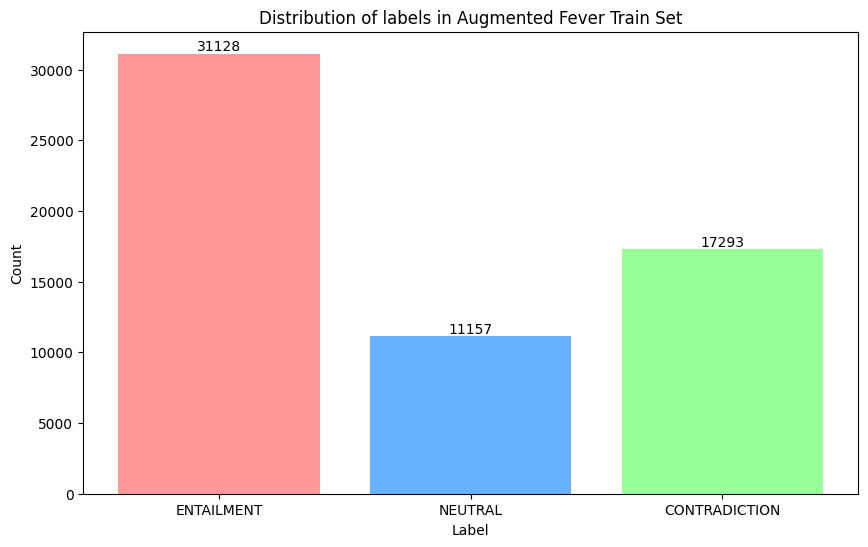

In [68]:
plot_labels_distribution(augmented_dataset, title="Augmented Fever Train Set")

In [72]:
tokenized_augmented_datasets = augmenetd_dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 59578/59578 [01:11<00:00, 829.54 examples/s]


In [77]:
tokenized_augmented_datasets

Dataset({
    features: ['id', 'premise', 'hypothesis', 'label', 'wsd', 'srl', 'input_ids', 'attention_mask'],
    num_rows: 59578
})

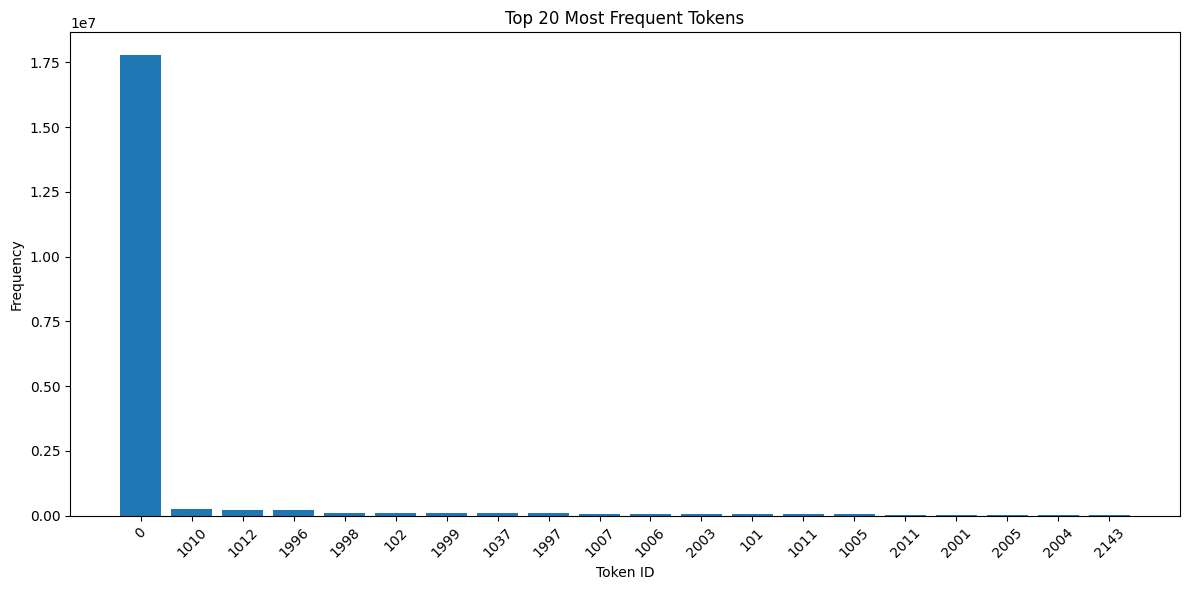

Total tokens: 22753952
Unique tokens: 22289

Most common tokens:
Token ID 0: 17773647 occurrences
Token ID 1010: 262370 occurrences
Token ID 1012: 232590 occurrences
Token ID 1996: 211723 occurrences
Token ID 1998: 120000 occurrences
Token ID 102: 119156 occurrences
Token ID 1999: 104519 occurrences
Token ID 1037: 88576 occurrences
Token ID 1997: 88469 occurrences
Token ID 1007: 75676 occurrences
Token ID 1006: 75524 occurrences
Token ID 2003: 73621 occurrences
Token ID 101: 59578 occurrences
Token ID 1011: 58600 occurrences
Token ID 1005: 53142 occurrences
Token ID 2011: 37706 occurrences
Token ID 2001: 36316 occurrences
Token ID 2005: 35696 occurrences
Token ID 2004: 35385 occurrences
Token ID 2143: 33580 occurrences

Most common tokens:
Token ID 0 ('[PAD]'): 17773647 occurrences
Token ID 1010 (','): 262370 occurrences
Token ID 1012 ('.'): 232590 occurrences
Token ID 1996 ('the'): 211723 occurrences
Token ID 1998 ('and'): 120000 occurrences
Token ID 102 ('[SEP]'): 119156 occurrences


In [80]:
analyze_token_frequency(tokenized_augmented_datasets, tokenizer)

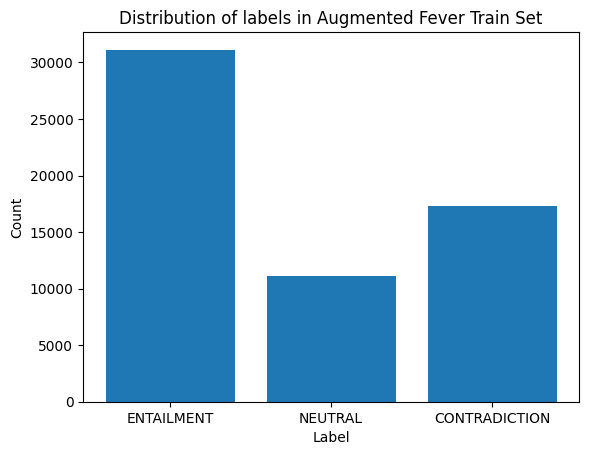

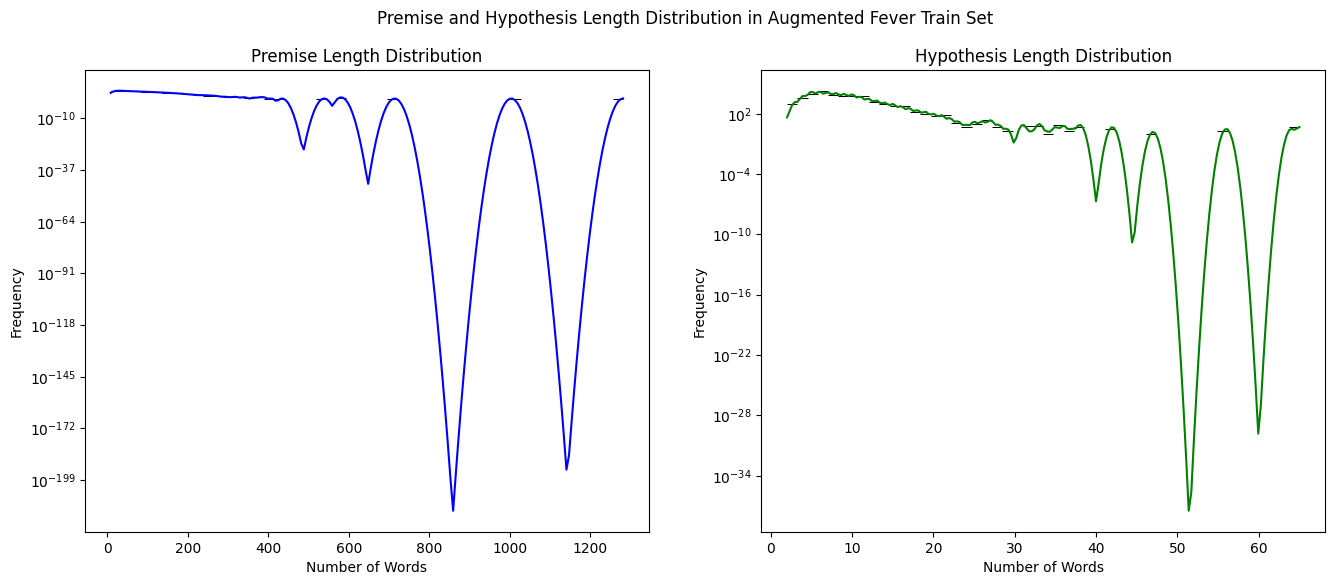

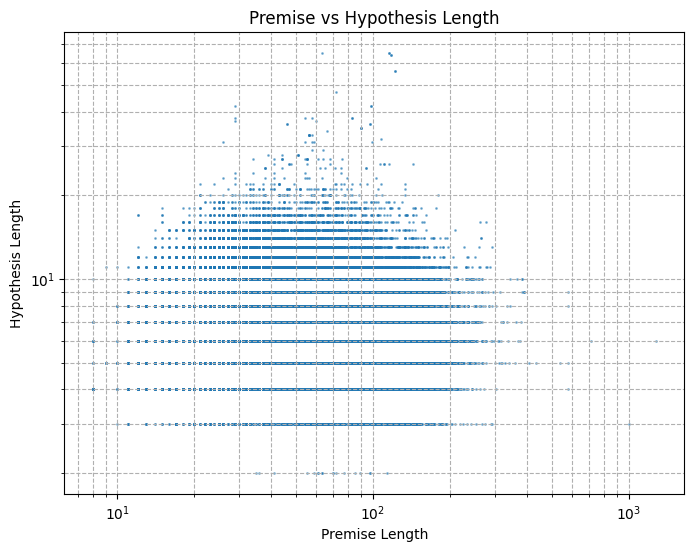

In [64]:
plot_lengths_distribution(augmented_dataset, title="Augmented Fever Train Set", compare_length=True)